In [2]:
import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

In [4]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==2.3.0
  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached keras_rl2-1.0.5-py3-none-any.whl (52 kB)


In [5]:
#build a data structre to manipulate Raw Data file

class RawData:

    def __init__(self, name='' ):
        self.name = name      
        
        
        
    def convert_mat_tocsv(self):

        mat = scipy.io.loadmat(self.name +'.mat')
        
        for i in mat:
            if '__' not in i and 'readme' not in i:
                 np.savetxt((self.name+".csv"), mat[i],delimiter=',')
                    
                    
    def read_data(self): 
        
        data = pd.read_csv(self.name+'.csv',
                  names=["Time_stamp(s)", "AC_Power(W)", "SOC(%)", "DC_Voltage(volt)",\
                        "DC_Current(A)", "Temperature(°C)"])
        return data
    
    

In [6]:
data_C10 = RawData('DataExpRaw_C10hW')
data_C25 = RawData('DataExpRaw_C25hW')
data_C50 = RawData('DataExpRaw_C50hW')
data_C75 = RawData('DataExpRaw_C75hW')
data_C100 = RawData('DataExpRaw_C100hW')
data_D10 = RawData('DataExpRaw_D10hW')
data_D25 = RawData('DataExpRaw_D25hW')
data_D50 = RawData('DataExpRaw_D50hW')
data_D75 = RawData('DataExpRaw_D75hW')
data_D100 = RawData('DataExpRaw_D100hW')



In [7]:
df_C10 = data_C10.read_data()
df_C25 = data_C25.read_data()
df_C100 = data_C100.read_data()
df_C50= data_C50.read_data()
df_C75= data_C75.read_data()
df_D10 = data_D10.read_data()
df_D25 = data_D25.read_data()
df_D100 = data_D100.read_data()
df_D50= data_D50.read_data()
df_D75= data_D75.read_data()


In [8]:
from torch import nn 
import gym 
from collections import deque 
import itertools 
import numpy as np 
import pandas as pd
import random 
from gym import Env 
from gym.spaces import Discrete, Box, Dict, Tuple , MultiBinary, MultiDiscrete
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
#define the data 
test_data= df_C75

In [10]:
testData = test_data.drop(['AC_Power(W)', 'Temperature(°C)'], axis=1)
testData


,Time_stamp(s),SOC(%),DC_Voltage(volt),DC_Current(A)
0,98368.628364,20.0,55.299999,-122.500000
1,98369.614420,20.0,55.299999,-122.500000
2,98370.595476,20.0,55.299999,-122.500000
3,98371.562531,20.0,55.299999,-122.500000
4,98372.533587,20.0,55.299999,-121.400002
...,...,...,...,...
47331,147711.189597,80.0,61.400002,-107.000000
47332,147712.160652,80.0,61.400002,-107.000000
47333,147713.156709,80.0,61.400002,-106.699997
47334,147714.132765,80.0,61.400002,-106.699997


In [11]:
raw, column= testData.shape
raw, column

(47336, 4)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from sympy.interactive import printing 
printing.init_printing(use_latex=True) 
from sympy import *
import sympy as sp 
import math

from scipy.integrate import solve_ivp

In [13]:
#define constant parameters
R= 8.314
F= 96486
z=1
#T= 23
T= 295.15  #K  (constant value )
NCell= 40
ILoss= 10 #A
U0 = 1.375 #V
Ri=0.00075  # mohm
CStor= 8700000 #As
#CStor= 2417

In [14]:
#define the initial guesses and the power cycle 

P=75
SoC = (testData.iloc[0].tolist()[1])/ 100  # expressed as a fraction
U = testData.iloc[0].tolist()[2]
I = testData.iloc[0].tolist()[3]


In [15]:
import math
import pandas as pd

delta_t = 1  # seconds

duration = testData.shape[0]

# Define a function to compute the power loss
def compute_Ploss(U, I):
    return U * I - P * 3600

# Define a function to compute the voltage U(I) using the bisection method
def compute_U_I(I):
    def f(U):
        return U * I - 1
    a = -10
    b = 10
    tol = 1e-6
    while b - a > tol:
        c = (a + b) / 2
        if f(c) == 0:
            return c
        elif f(a) * f(c) < 0:
            b = c
        else:
            a = c
    return (a + b) / 2

# Define lists to store the values of SoC, I, and U over time
SoC_list = []
I_list = []
U_list = []

# Initial guesses
SoC = testData.iloc[0].tolist()[1]  # expressed as a fraction
U= testData.iloc[0].tolist()[2]
I = testData.iloc[0].tolist()[3]

# Perform the simulation
for t in range(0, duration + delta_t, delta_t):
    # Update the current I
    I = I - delta_t * (-(I + ILoss)) / CStor

    # Compute the voltage U(I)
    U_I = compute_U_I(I)

    # Compute the voltage U
    U = NCell * U0 + ((NCell * R * T) / (z * F)) * math.log10(SoC**2 / (1 - SoC)**2) - NCell * I * Ri

    # Compute the power loss
    Ploss = compute_Ploss(U_I, I)

    # Update the state of charge SoC
    
    new_SoC = SoC - delta_t * (-(I + ILoss)) / CStor
    
  
    if new_SoC  >= 0.8:
        SoC = 0.8
    elif new_SoC <= 0.2:
        SoC = 0.2
    else:
        SoC = new_SoC

    # Append the new values to the lists
    SoC_list.append(SoC * 100)
    I_list.append(I)
    U_list.append(U)
    
    
SoC_list=  SoC_list[::-1]
I_list = I_list[::-1]
U_list = U_list[::-1]

        

Sim_df = pd.DataFrame(list(zip(SoC_list, U_list, I_list)), columns=['SoC(%)', 'Voltage(v)', 'Current(A)'])
#print(Sim_df)


In [16]:
Sim_df

,SoC(%),Voltage(v),Current(A)
0,20.000000,57.468464,-123.113785
1,20.000000,57.468463,-123.113772
2,20.000000,57.468463,-123.113759
3,20.000000,57.468463,-123.113746
4,20.000000,57.468462,-123.113733
...,...,...,...
47332,79.994828,59.899737,-122.500065
47333,79.996121,59.899808,-122.500052
47334,79.997414,59.899879,-122.500039
47335,79.998707,59.899950,-122.500026


In [17]:
testData

,Time_stamp(s),SOC(%),DC_Voltage(volt),DC_Current(A)
0,98368.628364,20.0,55.299999,-122.500000
1,98369.614420,20.0,55.299999,-122.500000
2,98370.595476,20.0,55.299999,-122.500000
3,98371.562531,20.0,55.299999,-122.500000
4,98372.533587,20.0,55.299999,-121.400002
...,...,...,...,...
47331,147711.189597,80.0,61.400002,-107.000000
47332,147712.160652,80.0,61.400002,-107.000000
47333,147713.156709,80.0,61.400002,-106.699997
47334,147714.132765,80.0,61.400002,-106.699997


In [18]:
#Sim_df.to_csv('Sim_df_C50.csv', index=False)
Sim_df= Sim_df[0: Sim_df.shape[0]-1]

In [19]:
import math
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [20]:
DataFrame = testData[:].to_numpy()
Sim_DataFrame = Sim_df[0:testData.shape[0]].to_numpy()


In [21]:
testData

,Time_stamp(s),SOC(%),DC_Voltage(volt),DC_Current(A)
0,98368.628364,20.0,55.299999,-122.500000
1,98369.614420,20.0,55.299999,-122.500000
2,98370.595476,20.0,55.299999,-122.500000
3,98371.562531,20.0,55.299999,-122.500000
4,98372.533587,20.0,55.299999,-121.400002
...,...,...,...,...
47331,147711.189597,80.0,61.400002,-107.000000
47332,147712.160652,80.0,61.400002,-107.000000
47333,147713.156709,80.0,61.400002,-106.699997
47334,147714.132765,80.0,61.400002,-106.699997


In [22]:
class BatteryEnv(Env): 
    
    def __init__(self):
        
        #define the action space
        self.action_space= Discrete(3) 
        #define the observation space
        self.observation_space= Box(low=np.min(DataFrame), high=np.max(DataFrame), shape=(DataFrame.shape[0],DataFrame.shape[1]), dtype=np.float32)
        self.current = 1
        self.P= 75
        self.R=  8.314
        self.F=  96486
        self.T=  295.15
        self.z= 1
        self.NCell = 40
        self.length=60
        #define the specific parameters 
        #represents the episode length 
        self.ILoss= 10 #A
        self.U0 = 1.375 #V
        self.Ri= 0.00075 # ohm
        self.CStor= 8700000 #As 
        
        self.SoC0= DataFrame[0][1]/ 100 
        self.I0= DataFrame[0][3]
        self.U_0= DataFrame[0][2]
        
        self.parameters= torch.tensor([self.ILoss,  self.U0,  self.Ri, self.CStor], dtype=torch.float32) 
     
        def get_raw_state(current):
            sample_array = self.observation_space.sample()
            sample_array[:] = DataFrame
            row = sample_array[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
        
        def get_sim_state(current):
          
            row = Sim_DataFrame[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
        
        
        self.raw_state = get_raw_state(self.current)
        self.sim_state = get_sim_state(self.current)
        
        self.current_loss=  abs(self.raw_state[1]- self.sim_state[0])+ abs(self.raw_state[2]- self.sim_state[1])+abs(self.raw_state[3]- self.sim_state[2])

        #define initial state 
        self.state= torch.cat((self.raw_state , self.sim_state, self.parameters),0)


    def step (self, action): 
        
        def battery_simulation(ILoss, U0, Ri, CStor, SoC0, I0, U_0, P):
            SoC = SoC0/100
            I = I0
            U =  U_0
            P= self.P 
            
            
            duration = DataFrame.shape[0]
            delta_t = 1  # seconds
 
            def compute_Ploss(U, I):
                 return U * I - P * 3600

            def compute_U_I(I):
                def f(U):
                    return U * I - 1
                a = -10
                b = 10
                tol = 1e-6
                while b - a > tol:
                    c = (a + b) / 2
                    if f(c) == 0:
                         return c
                    elif f(a) * f(c) < 0:
                        b = c
                    else:
                        a = c
                        return (a + b) / 2

            SoC_list = []
            I_list = []
            U_list = []

            
            for t in range(0, duration + delta_t, delta_t):
                I = I - delta_t * (-(I + self.ILoss) )/ self.CStor

                U_I = compute_U_I(I)

                U = self.NCell * self.U0 + ((self.NCell * self.R * self.T) / (self.z * self.F)) * math.log10(SoC**2 / (1 - SoC)**2) - self.NCell * I * Ri

                Ploss = compute_Ploss(U_I, I)

                new_SoC = SoC - delta_t * (-(I + self.ILoss)) / self.CStor

                if new_SoC >= 0.8: 
                     SoC = 0.8
                elif new_SoC <= 0.2 : 
                     SoC=0.2
                else:
                     SoC = new_SoC

                SoC_list.append(SoC*100)
                I_list.append(I)
                U_list.append(U)
                
            SoC_list=  SoC_list[::-1]
            I_list = I_list[::-1]
            U_list = U_list[::-1]
        
            Sim_df = pd.DataFrame(list(zip(SoC_list,U_list, I_list)), columns=['SoC(%)','Voltage(v)', 'Current(A)'])
            transition_df = Sim_df[0:DataFrame.shape[0]].to_numpy()

            return  transition_df
            
      
        #Increase specific parameters 
        if action == 1 : 
            self.ILoss += 0.005
            self.U0 += 0.005
            self.Ri += 0.005
            self.CStor += 50
            

        #decrease specific parameters 
        elif action == 2 : 
            self.ILoss -= 0.005
            self.U0 -=  0.005
            self.Ri -=  0.005
            self.CStor -= 50 

        #Maintain specific parameters 
        else : 
            self.ILoss += action 
            self.U0 += action
            self.Ri += action
            self.CStor += action
         
                
        self.parameters= torch.tensor([self.ILoss,  self.U0,  self.Ri, self.CStor], dtype=torch.float32) 
        
        #calculate the new sim with new self .parameters 
        sim_data = battery_simulation(self.ILoss,  self.U0,  self.Ri, self.CStor , SoC0= self.SoC0 , I0= self.I0, U_0= self.U_0, P= self.P)
        
        def get_sim_state_new(current):
            row = sim_data[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
        
        def get_raw_state(current):
            sample_array = self.observation_space.sample()
            sample_array[:] = DataFrame
            row = sample_array[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
        

        self.sim_state= get_sim_state_new(self.current)
        self.raw_state= get_raw_state(self.current)

        
        self.length-=1
        
        #calculate the reward for a given action   
        #ERROR = np.mean((np.array([self.state[1], self.state[2], self.state[3]]) - np.array([self.sim_state[4], self.sim_state[5],self.sim_state[6]]))**2)
        best_loss = float('inf') 
        weight_SoC = 1
        weight_I = 1
        weight_U = 1
        gamma= 10

        score_SoC = abs(self.state[1]- self.sim_state[0])
        score_U = abs(self.state[2]- self.sim_state[1])
        score_I = abs(self.state[3]- self.sim_state[2])
        
        ERROR =  weight_SoC*score_SoC + weight_U *score_U + weight_I*score_I 
        
        val_loss= self.current_loss
        
        if ERROR < best_loss:
             best_loss = ERROR
        
        reward = gamma* (best_loss - val_loss) 
        #reward = gamma* (best_loss - val_loss) 

        #reward= -ERROR
        #reward = 10/ ERROR + 0.001
        
    
    
        def get_sim_state(current):
            row = Sim_DataFrame[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
                
        self.current = random.randint(self.current,DataFrame.shape[0]-10)
        self.raw_state= get_raw_state(self.current)
        self.sim_state= get_sim_state(self.current)

        self.state= torch.cat((self.raw_state, self.sim_state, self.parameters),0)
        
        if self.length <= 0 : 
            done = True 
            
        else: 
            done= False 
            
            
        info= {self.parameters}

            

        return  self.state, reward , done , info 
    
    
    def render(self):
        pass
    
     
    def reset(self): 
        self.ILoss= 10 #A
        self.U0 = 1.375 #V
        self.Ri= 0.00075  #m ohm
        self.CStor= 8700000 #Ah 
        self.current=1
        self.length=60
        
        self.parameters= torch.tensor([self.ILoss,  self.U0,  self.Ri, self.CStor], dtype=torch.float32)
        
        def get_raw_state(current):
            sample_array = self.observation_space.sample()
            sample_array[:] = DataFrame
            row = sample_array[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
           
        def get_sim_state(current):
            row = Sim_DataFrame[current]
            state = torch.tensor(row, dtype=torch.float32)
            return state
        
        self.raw_state = get_raw_state(self.current)
        self.sim_state = get_sim_state(self.current)
        self.state= torch.cat((self.raw_state, self.sim_state, self.parameters),0)

        return self.state

In [23]:
env = BatteryEnv()
states = env.observation_space.shape[0]
actions = env.action_space.n

In [24]:
env.reset()

tensor([ 9.8370e+04,  2.0000e+01,  5.5300e+01, -1.2250e+02,  2.0000e+01,
         5.7468e+01, -1.2311e+02,  1.0000e+01,  1.3750e+00,  7.5000e-04,
         8.7000e+06])

In [25]:
#test the environment 
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{} state : {}'.format(episode, score, n_state))

Episode:1 Score:186390.921875 state : tensor([ 1.4771e+05,  8.0000e+01,  6.1400e+01, -1.0720e+02,  7.9987e+01,
         5.9899e+01, -1.2250e+02,  1.0090e+01,  1.4650e+00,  9.0750e-02,
         8.7009e+06])


In [26]:
env.step(9)

(tensor([ 1.4771e+05,  8.0000e+01,  6.1400e+01, -1.0720e+02,  7.9987e+01,
          5.9899e+01, -1.2250e+02,  1.9090e+01,  1.0465e+01,  9.0907e+00,
          8.7009e+06]),
 tensor(449732.1875),
 True,
 {tensor([1.9090e+01, 1.0465e+01, 9.0907e+00, 8.7009e+06])})

In [27]:
env.step(3)

(tensor([ 1.4771e+05,  8.0000e+01,  6.1400e+01, -1.0720e+02,  7.9987e+01,
          5.9899e+01, -1.2250e+02,  2.2090e+01,  1.3465e+01,  1.2091e+01,
          8.7009e+06]),
 tensor(597932.3750),
 True,
 {tensor([2.2090e+01, 1.3465e+01, 1.2091e+01, 8.7009e+06])})

In [28]:
env.reset()

tensor([ 9.8370e+04,  2.0000e+01,  5.5300e+01, -1.2250e+02,  2.0000e+01,
         5.7468e+01, -1.2311e+02,  1.0000e+01,  1.3750e+00,  7.5000e-04,
         8.7000e+06])

In [29]:
pip install opencv-python


  Using cached opencv_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [30]:
import collections 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import gym 


In [31]:
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 


In [32]:
import tensorboard
%load_ext tensorboard

In [33]:
class DeepQNetwork (nn.Module): 
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions): 
        
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions= n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2= nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3= nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer= optim.Adam(self.parameters(), lr=lr)
        self.loss= nn.MSELoss()
        self.device= T.device( 'cpu')

        
    def forward (self, state): 
        x= F.relu(self.fc1(state))
        x= F.relu(self.fc2(x))
        actions= self.fc3(x) 
        
        return actions
    
    def save(self, filename): 
        T.save(self.state_dict(), 'Training/logs'+filename)
        
    def load(self, filename): 
        T.load('Training/logs'+filename) 
        
        
    def eval(self):
        self.train(False)  # Set the model to evaluation mode
   
        super(DeepQNetwork, self).eval()  # Call the parent class's eval() function
   

In [34]:
class Agent(): 
    
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                     max_mem_size=100000, eps_end= 0.01 , eps_dec= 5e-4, fname= 'three_actions_1.pth'):
                 
            self.gamma= gamma
            self.epsilon= epsilon
            self.eps_min= eps_end
            self.eps_dec= eps_dec
            self.lr=lr
            self.action_space= [i for i in range (n_actions)]
            self.mem_size= max_mem_size 
            self.batch_size= batch_size 
            self.mem_cntr =0 

            self.Q_eval= DeepQNetwork (self.lr, n_actions=n_actions, input_dims=input_dims,
                                       fc1_dims=256, fc2_dims=256)
            
            self.state_memory= np.zeros ((self.mem_size, *input_dims), dtype= np.float32)
            
            self.new_state_memory= np.zeros ((self.mem_size, *input_dims),
                                               dtype = np.float32)
            
            self.action_memory = np.zeros(self.mem_size, dtype =np.int32)
            self.reward_memory = np.zeros(self.mem_size, dtype =np.float32)
            self.terminal_memory = np.zeros(self.mem_size, dtype = np.bool_)
            self.model_file= fname

    def store_transition (self, state, action, reward, state_, done) : 
        index = self.mem_cntr %  self.mem_size 
        self.state_memory[index]= state
        self.new_state_memory[index]= state_
        self.reward_memory[index]= reward 
        self.action_memory[index]= action 
        self.terminal_memory[index]= done
        
        self.mem_cntr+=1 
        
    def choose_action(self,observation):
        if np.random.random()>self.epsilon : 
            state= observation.clone().detach().requires_grad_(True).to(self.Q_eval.device)
            actions= self.Q_eval.forward(state)
            action = T.argmax(actions).item()
            
        else:
            action= np.random.choice(self.action_space)
            
        return action 

    def learn(self):
        if self.mem_cntr < self.batch_size: 
            return 
        
        self.Q_eval.optimizer.zero_grad()
        max_mem= min (self.mem_cntr, self.mem_size)
        batch= np.random.choice (max_mem, self.batch_size, replace=False)
        
        
        batch_index = np.arange (self.batch_size, dtype = np.int32)
        
        state_batch= T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch= T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch= T.tensor (self.terminal_memory[batch]).to(self.Q_eval.device)
                               
        action_batch= self.action_memory[batch]
        q_eval= self.Q_eval.forward(state_batch)[batch_index, action_batch].to(self.Q_eval.device)
        q_next= self.Q_eval.forward (new_state_batch).to(self.Q_eval.device)
        q_next[terminal_batch]= 0.0
                               
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        loss= self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
                               
        self.epsilon= self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                               else self.eps_min
             
    def save_model(self): 
        self.Q_eval.save(self.model_file) 
        
    def load_model(self): 
        self.Q_eval.load(self.model_file)
     
    def eval_model(self): 
        self.Q_eval.eval()

    def predict(self, obs):
        self.Q_eval.eval()  # Set the model to evaluation mode
        observation_tensor = T.tensor(obs).clone().detach().requires_grad_(True) # Convert observation to a tensor

        with T.no_grad():
            predicted_action = self.Q_eval(observation_tensor)  # Pass the observation through the model

        action = T.argmax(predicted_action).item() # Get the index of the predicted action

        return action


In [35]:
pip install tensorboardX


  Using cached tensorboardX-2.6.1-py2.py3-none-any.whl (101 kB)
  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
Note: you may need to restart the kernel to use updated packages.


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


In [37]:
from tensorboardX import SummaryWriter
writer = SummaryWriter("Training/logs")


In [38]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==2.3.0


episode 0 score 105783.84 average score 105783.84 epsilon 1.00
episode 1 score 83953.16 average score 94868.50 epsilon 0.97
episode 2 score 94134.12 average score 94623.71 epsilon 0.94
episode 3 score 71239.41 average score 88777.63 epsilon 0.91
episode 4 score 158742.31 average score 102770.57 epsilon 0.88
episode 5 score 185537.92 average score 116565.12 epsilon 0.85
episode 6 score 160092.88 average score 122783.38 epsilon 0.82
episode 7 score 255527.08 average score 139376.34 epsilon 0.79
episode 8 score 188805.95 average score 144868.53 epsilon 0.76
episode 9 score 116691.57 average score 142050.84 epsilon 0.73
episode 10 score 119653.26 average score 140014.69 epsilon 0.70
episode 11 score 238409.97 average score 148214.30 epsilon 0.67
episode 12 score 162773.98 average score 149334.28 epsilon 0.64
episode 13 score 320827.31 average score 161583.78 epsilon 0.61
episode 14 score 202130.47 average score 164286.91 epsilon 0.58
episode 15 score 268471.19 average score 170798.41 epsil

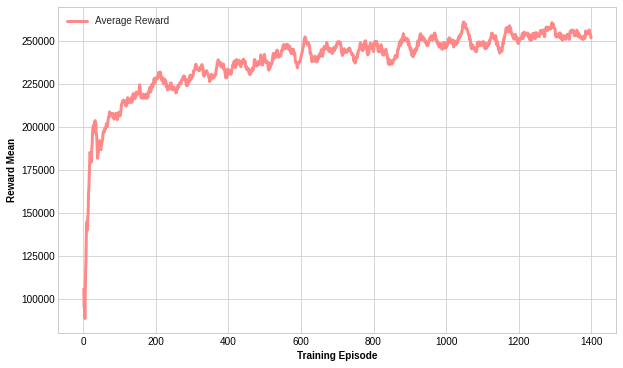

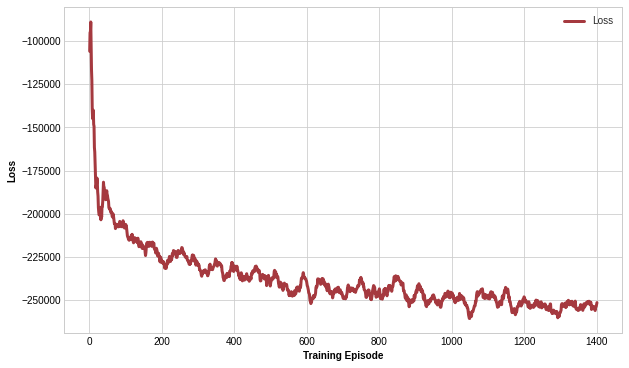

In [39]:
def plot_learning_curve(x, scores, epsilons, filename , lines=None):
    
    fig=plt.figure(figsize=(10,6))
    #ax= fig.add_subplot(111, label ="1")
    #ax2= fig.add_subplot(111, label ="2", frame_on = False )
    ax2 = plt.axes()
    
    #ax.plot(x,epsilons, color="C0")
    #ax.set_xlabel("Training Steps", color= "C0")
    #ax.set_ylabel("Epsilon", color="C0")
    #ax.tick_params(axis='x', colors="C0")
    #ax.tick_params(axis='y', colors="C0")
    
    N=len(scores)
    running_avg= np.empty(N)
    for t in range(N):
        running_avg[t]= np.mean(scores[max(0, t-20): (t+1)])
     
    #ax2.line(x, running_avg, line_color="#ff8888", line_width=3, alpha=0.7, legend_label="Avg_rew")

    ax2.plot(x, running_avg, color= "#ff8888", label='Average Reward', lw= 3)
    ax2.legend()
    ax2.set_xlabel("Training Episode", color= "0",fontweight='bold')
    #ax2.set_ylabel("Epsilon", color="C0")
    #ax2.axes.get_xaxis().set_visible(False)
    #ax2.yaxis.tick_right()
    ax2.set_ylabel('Reward Mean', color="0", fontweight='bold')
    ax2.tick_params(axis='x', colors="0")
    ax2.tick_params(axis='y', colors="0")
    
    #ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='y', colors= "C1")
    
    if lines is not None : 
        for line in lines: 
            plt.axvline(x=line)
            
    plt.savefig(filename)  
    
def plot_learning_curve2(x, errors, epsilons, filename , lines=None):
    
    fig=plt.figure(figsize=(10,6))
    #ax= fig.add_subplot(111, label ="1")
    #ax2= fig.add_subplot(111, label ="2", frame_on = False )
    ax2 = plt.axes()
    
    #ax.plot(x,epsilons, color="C0")
    
    #ax.set_xlabel("Training Steps", color= "C0")
    #ax.set_ylabel("Epsilon", color="C0")
    #ax.tick_params(axis='x', colors="C0")
    #ax.tick_params(axis='y', colors="C0")
    
    N=len(errors)
    running_avg= np.empty(N)
    for t in range(N):
        running_avg[t]= np.mean(errors[max(0, t-20): (t+1)])
     
    #ax2.line(x, running_avg, line_color="#ff8888", line_width=3, alpha=0.7, legend_label="Avg_rew")

    ax2.plot(x, running_avg, color= "#A5393F", label='Loss', lw= 3)
    ax2.legend()
    ax2.set_xlabel("Training Episode", color= "0",fontweight='bold')
    #ax2.set_ylabel("Epsilon", color="C0")
    #ax2.axes.get_xaxis().set_visible(False)
    #ax2.yaxis.tick_right()
    ax2.set_ylabel('Loss', color="0", fontweight='bold')
    ax2.tick_params(axis='x', colors="0")
    ax2.tick_params(axis='y', colors="0")
    
    #ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='y', colors= "C1")
    
    if lines is not None : 
        for line in lines: 
            plt.axvline(x=line)
            
    plt.savefig(filename)  
    
    
if __name__==  '__main__':
    
    env= BatteryEnv()
    
    if not os.path.isdir('models'):
         os.makedirs('models')
    agent = Agent(gamma=0.99 , epsilon= 1.0 , batch_size=64, n_actions=3, 
                 eps_end=0.01, input_dims=[11], lr=0.01, fname= 'three_actions_1.pth')
    scores, eps_history, avg_scores , errors =[],[],[],[]
    n_games=1400
    

    for i in range (n_games):
        score=0
        error=0
        done=False
        #agent.tensorboard.step = i

        observation = env.reset()
        while not done : 
            action =agent.choose_action(observation)
            observation_, reward, done, info= env.step(action)
            score+= reward 
            error+= (-reward)
            agent.store_transition(observation, action, reward, 
                                   observation_, done)
            
            agent.learn()
            observation = observation_
        scores.append(score)
        errors.append(error)
        eps_history.append(agent.epsilon)
        

        
        avg_score= np.mean(scores[-100:])
        print('episode',i, 'score %.2f' % score,
              'average score %.2f' % avg_score, 
              'epsilon %.2f' % agent.epsilon
               )
        
        if i % 10==0 and i>0 : 
            agent.save_model()
            
        writer.add_scalar('Avg_rew/train', avg_score, global_step=i)
        
        writer.add_scalar('epsilon/train', agent.epsilon, global_step=i)
  
        avg_scores.append(avg_score)
    writer.close()
    x= [i+1 for i in range (n_games)]
    df_result= pd.DataFrame(list(zip(x, scores, avg_scores, errors)), columns=['Episode ', 'Scores', 'avg_scores', 'Error'])
    df_result.to_csv('new_75_222.csv', index=False)
    filename1='three_actions_1_re.png'
    filename2='three_actions_1_loss.png'

    plot_learning_curve(x, scores, eps_history, filename1)
    plot_learning_curve2(x, errors, eps_history, filename2)

                
        